|变量|说明|标签|
|:--:|:--:|:--|
|NO|编号|-|
|salary|收入|1:[0 1000], 2:[1000 3000], 3:[3001 5000], 4:[5001 7000], 5:[7001 9000], 6:>9000|
|educ|教育程度|1:高中以下, 2:大专, 3:本科, 4:大于硕士|
|freq|频次|1:1次, 2:2-3次, 3:4-5次, 4:6-8次, 5:9-12次, 6:>13次|
|compan|购物原因|1:家人,2:情人, 3:朋友, 4: 同学, 5:客户, 6:无聊|
|purpose|目的|1:享受, 2:陪同异性, 3:生活用品, 4:公事, 5:无聊|
|average|单次平均消费|1:小于50, 2:[50 99], 3: [100,149], 4:[150 199], 5:≥200|

In [1]:
%matplotlib inline
import pandas as pd

df = pd.read_csv('shopping.csv')
df.head() 

,NO,salary,educ,freq,compan,purpose,average
0,1,3,4,4,3,2,2
1,2,4,4,1,1,1,2
2,3,3,3,6,2,1,2
3,4,4,4,2,3,2,4
4,5,1,3,1,3,2,2


In [2]:
purpose_dict = {1:'enjoyment', 2:'opposite sex', 3:'daily use', 
                4:'business', 5:'no reason'}
average_dict = {1:'<50', 2:'[50 99]', 3:'[100 149]', 4:'[150 199]', 
                5:'>200'}
df.purpose.replace(purpose_dict, inplace=True)
df.average.replace(average_dict, inplace=True)

cross_table = pd.crosstab(df.purpose, df.average)
cross_table

average,<50,>200,[100 149],[150 199],[50 99]
purpose,,,,,
business,1,4,9,4,4
daily use,1,2,10,3,9
enjoyment,0,6,15,7,48
no reason,3,1,1,0,5
opposite sex,8,6,15,12,48


In [4]:
import numpy as np
from numpy.linalg import svd

class CA(object):
    """Simple corresondence analysis.
    
    Inputs
    ------
    ct : array_like, shape (n_samples, n_features)
      Two-way contingency table, training set, where `n_samples`
      is the number of samples and `n_features` is the number of features.
          
    Attributes
    ------
    F_ : array, shape (n_features, K)
      principal coordinates of columns. Where `K` = min(`n_features`, `n_samples`).
      
    G_ : array, shape (n_samples, K)
      principal coordinates of rows. Where `K` = min(`n_features`, `n_samples`).
    
    explained_variance_ratio_ : array, shape(K, )
      Percentage of variance explained by each of the selected components.
    
    Notes
    -----
    The implementation follows that presented in 'Correspondence
    Analysis in R, with Two- and Three-dimensional Graphics: The ca
    Package,' Journal of Statistical Software, May 2007, Volume 20,
    Issue 3.
    """
    
    def __init__(self, cross_table):
        N = np.matrix(cross_table, dtype=float)

        # correspondence matrix from contingency table
        P = N / N.sum()

        # row and column marginal totals of P as vectors
        r = P.sum(axis=1)
        c = P.sum(axis=0).T

        # diagonal matrices of row/column sums
        D_r_rsq = np.diag(1. / np.sqrt(r.A1))
        D_c_rsq = np.diag(1. / np.sqrt(c.A1))

        # the matrix of standarized residuals
        Z = D_r_rsq * (P - r * c.T) * D_c_rsq

        # compute the SVD
        U, D_a, V = svd(Z, full_matrices=False)
        D_a = np.asmatrix(np.diag(D_a))
        V = V.T

        # principal coordinates of columns
        F = D_c_rsq * V * D_a

        # principal coordinates of rows
        G = D_r_rsq * U * D_a

        # standard coordinates of rows
        X = D_r_rsq * U

        # standard coordinates of columns
        Y = D_c_rsq * V

        eigenvals = np.diagonal(D_a) ** 2
        explained_variance_ratio = eigenvals.cumsum() / eigenvals.sum()

        # the total variance of the data matrix 
        inertia = sum([(P[i,j] - r[i,0] * c[j,0])**2 / (r[i,0] * c[j,0])
                       for i in range(N.shape[0])
                       for j in range(N.shape[1])])  # equals np.power(S, 2).sum() or eigenvalus.sum() or np.trace(S.T * S)

        self.F_ = F.A
        self.G_ = G.A
        self.inertia_ = inertia
        self.eigenvals_ = eigenvals
        self.explained_variance_ratio_ = explained_variance_ratio

In [5]:
ca = CA(cross_table)

print(ca.explained_variance_ratio_)

[ 0.51057984  0.92001143  0.96850523  1.          1.        ]


R型和Q型分析的特征向量（加权后）

In [6]:
F = ca.F_ 
G = ca.G_

print(F[:, :2])

[[ 0.75903754 -0.81340802]
 [-0.22718477 -0.2089492 ]
 [-0.38023687 -0.15354446]
 [-0.19191092 -0.0661804 ]
 [ 0.16184693  0.21001976]]


绘制感知图

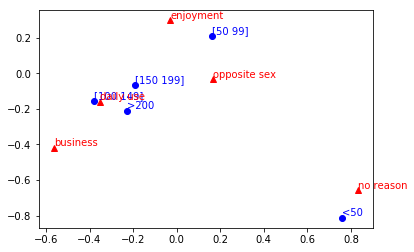

In [7]:
import matplotlib.pyplot as plt

for i, s in enumerate(cross_table.columns):
    x, y = F[i, 0], F[i, 1]
    plt.plot(x, y, 'bo')
    plt.text(x, y, s, va='bottom', ha='left', color='b')
    
for i, s in enumerate(cross_table.index):
    x, y = G[i, 0], G[i, 1]
    plt.plot(x, y, 'r^')
    plt.text(x, y, s, va='bottom', ha='left', color='r')